In [2]:
%matplotlib inline

/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import numpy as np, scipy as sp
import scipy.io
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib

from imp import reload

import tools.matlabtools

In [5]:
from tools.bootstrap import *
# from pytools.signal import wavelets as mmwt
# lets = mmwt.CWTlets
# this is dodgy, please fix this

In [6]:
matplotlib.style.use('ggplot')

In [7]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

In [8]:
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
           vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())
    
def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

Data loading section

In [10]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = tools.matlabtools.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [11]:
brief = data[:SR*120]
brief.shape

(48000, 16)

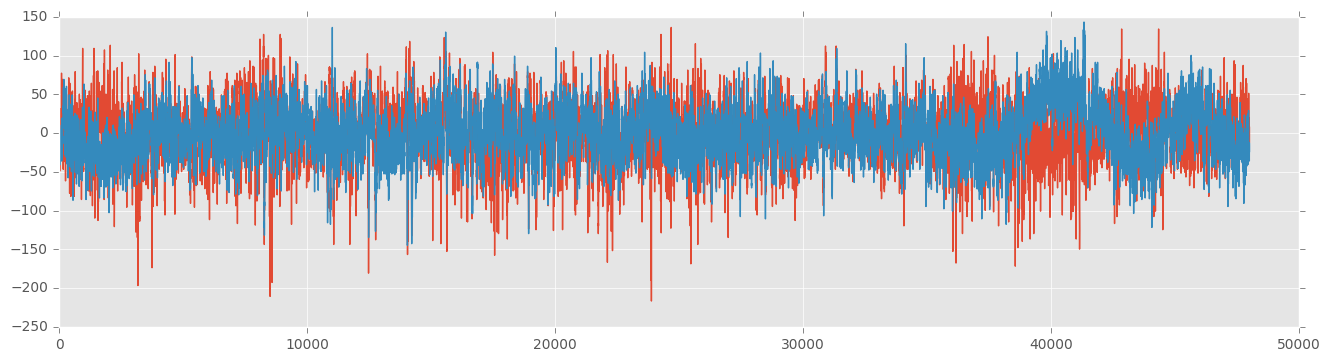

In [12]:
plt.plot(brief[:,:2])

In [10]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [11]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

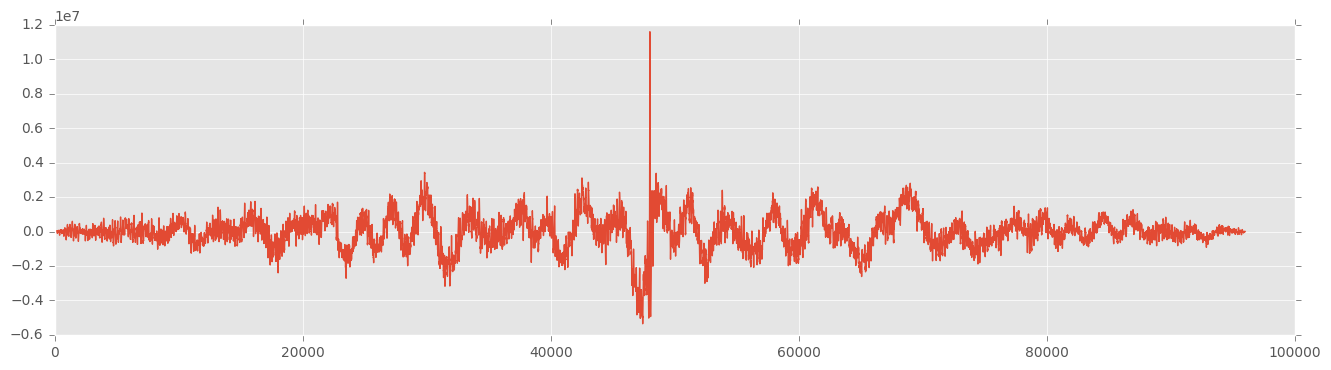

In [15]:
corr12 = signal.correlate(eeg1, eeg2)
plt.plot(corr12)

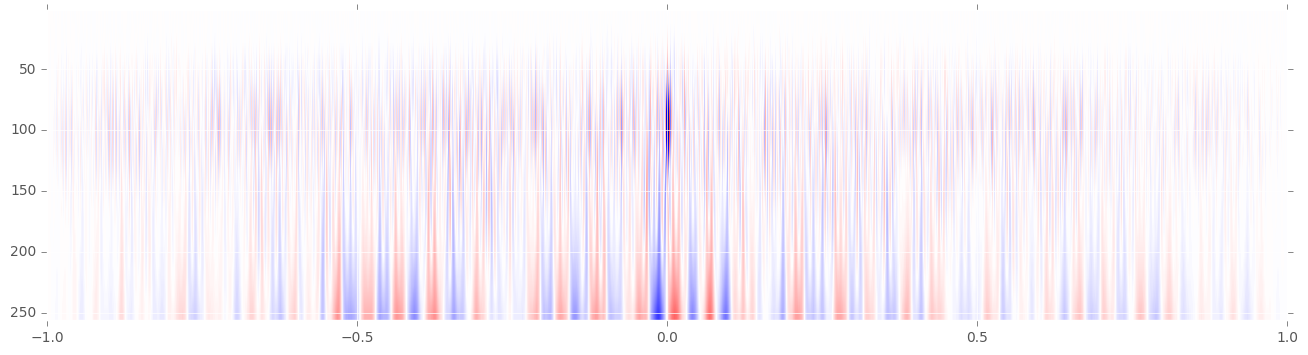

In [16]:
plt_easycwt(plt, corr12, widths)

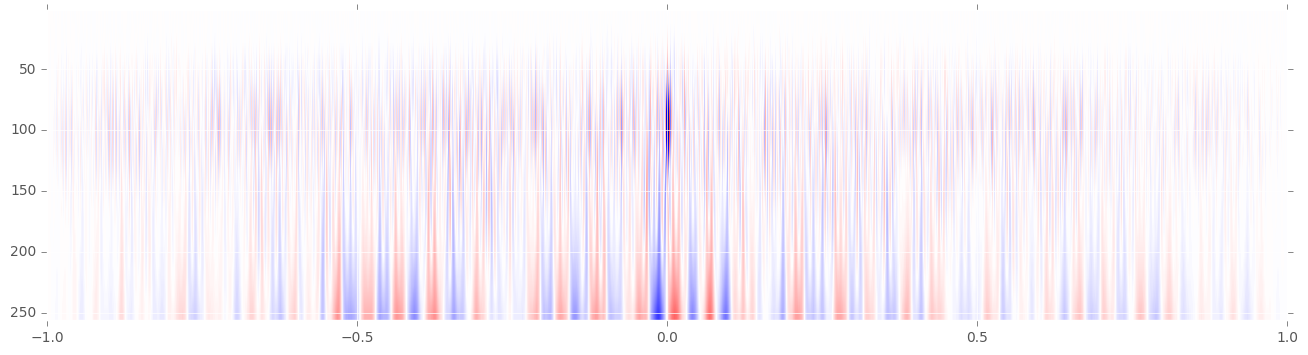

In [17]:
plt_easycwt(plt, corr12, widths)

In [18]:
reload(mmwt)

<module 'pytools.signal.wavelets' from '/home/mm/py/gitlab/pytools/signal/wavelets.py'>

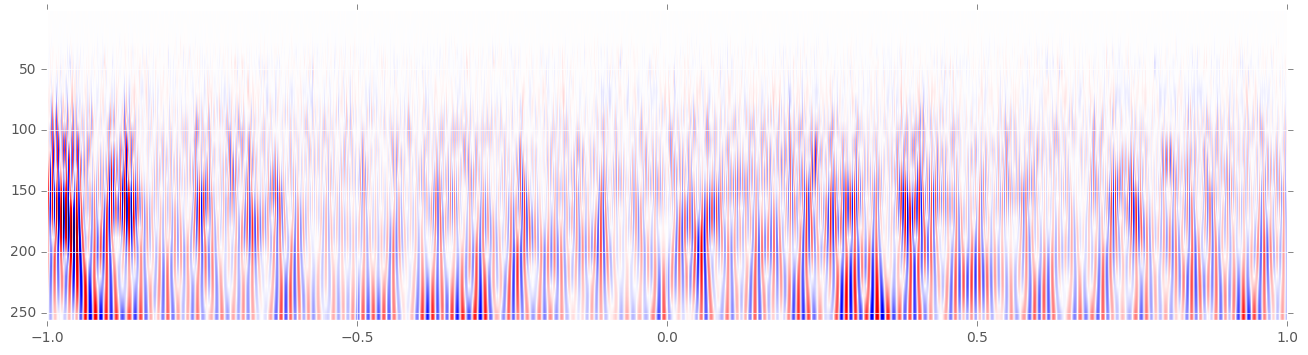

In [19]:
eeg1_mt = signal.cwt(eeg1, lets.morlet_i, widths)
pltcwt(plt, eeg1_mt, widths)

In [20]:
# translation of the Matlab feature extractor
import sys
import os
import numpy as np
import pandas as pd
from math import *
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
#import pyeeg 
# pyeeg is the one that has very good fractal dimensions 
# computation but not installed here

def mat_to_data(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    return ndata

def corr(data,type_corr):
    C = np.array(data.corr(type_corr))
    C[np.isnan(C)] = 0
    C[np.isinf(C)] = 0
    w,v = np.linalg.eig(C)
    #print(w)
    x = np.sort(w)
    x = np.real(x)
    return x

def calculate_features(file_name, verbose=False):
    f = mat_to_data(file_name)
    fs = f['iEEGsamplingRate'][0,0]
    eegData = f['data']
    [nt, nc] = eegData.shape
    print((nt, nc))
    subsampLen = floor(fs * 60)# //2
    numSamps = int(floor(nt / subsampLen));      # Num of 1-min samples
    sampIdx = range(0,(numSamps+1)*subsampLen,subsampLen)
    #print(sampIdx)
    feat = [] # Feature Vector
    featdict = {}
    featary = []
    for i in range(1, numSamps+1):
        print(len(feat))
        print('processing file {} epoch {}'.format(file_name,i))
        epoch = eegData[sampIdx[i-1]:sampIdx[i], :]

        # compute Shannon's entropy, spectral edge and correlation matrix
        # segments corresponding to frequency bands
        if verbose: print("Calculating Shannon entroy, spectral edge, correlation matrix")
        lvl = np.array([0.1, 4, 8, 12, 30, 70, 180])  # Frequency levels in Hz
        lseg = np.round(nt/fs*lvl).astype('int')
        D = np.absolute(np.fft.fft(epoch, n=lseg[-1], axis=0))
        D[0,:]=0                                # set the DC component to zero
        D /= D.sum()                      # Normalize each channel               
        
        dspect = np.zeros((len(lvl)-1,nc))
        for j in range(len(dspect)):
            dspect[j,:] = 2*np.sum(D[lseg[j]:lseg[j+1],:], axis=0)

        if verbose: print("...Shannon entropy")
        # Find the shannon's entropy
        spentropy = -1*np.sum(np.multiply(dspect,np.log(dspect)), axis=0)

        if verbose: print("...Spectra edge")
        # Find the spectral edge frequency
        sfreq = fs
        tfreq = 40
        ppow = 0.5

        topfreq = int(round(nt/sfreq*tfreq))+1
        A = np.cumsum(D[:topfreq,:])
        B = A - (A.max()*ppow)
        spedge = np.min(np.abs(B))
        spedge = (spedge - 1)/(topfreq-1)*tfreq

        if verbose: print("...Correlation matrix and eigenvalues, channels")
        # Calculate correlation matrix and its eigenvalues (b/w channels)
        data = pd.DataFrame(data=epoch)
        type_corr = 'pearson'
        lxchannels = corr(data, type_corr)
        
        if verbose: print("...Correlation matrix and eigenvalues, frequencies")
        # Calculate correlation matrix and its eigenvalues (b/w freq)
        data = pd.DataFrame(data=dspect)
        lxfreqbands = corr(data, type_corr)
        
        if verbose: print("...Spectral entropy for dyadic bands")
        # Spectral entropy for dyadic bands
        # Find number of dyadic levels
        ldat = int(floor(nt/2.0))
        no_levels = int(floor(log(ldat,2.0)))
        seg = floor(ldat/pow(2.0, no_levels-1))

        if verbose: print("...Power spectrum at each dyadic level")
        # Find the power spectrum at each dyadic level
        dspect = np.zeros((no_levels,nc))
        for j in range(no_levels-1,-1,-1):
            dspect[j,:] = 2*np.sum(D[int(floor(ldat/2.0))+1:ldat,:], axis=0)
            ldat = int(floor(ldat/2.0))

        if verbose: print("...Shannon's entropy")
        # Find the Shannon's entropy
        spentropyDyd = -1*np.sum(np.multiply(dspect,np.log(dspect)), axis=0)

        if verbose: print("...Inter-Channel correlation")
        # Find correlation between channels
        data = pd.DataFrame(data=dspect)
        lxchannelsDyd = corr(data, type_corr)
        
        if verbose: print("...Fractal dimensions")
        # Fractal dimensions
        no_channels = nc
        #fd = np.zeros((2,no_channels))
        #for j in range(no_channels):
        #    fd[0,j] = pyeeg.pfd(epoch[:,j])
        #    fd[1,j] = pyeeg.hfd(epoch[:,j],3)
        #    fd[2,j] = pyeeg.hurst(epoch[:,j])

        #[mobility[j], complexity[j]] = pyeeg.hjorth(epoch[:,j)
        # Hjorth parameters
        # Activity
        activity = np.std(epoch, axis=0) # activity is totally crazy big, std is much nicer to work with
        # considering the amount of cowboy code in this script, I doubt it impacts things too much
#         activity = np.var(epoch, axis=0)

        #print('Activity shape: {}'.format(activity.shape))
        # Mobility
        mobility = np.divide(
                            np.std(np.diff(epoch, axis=0)), 
                            np.std(epoch, axis=0))
        #print('Mobility shape: {}'.format(mobility.shape))
        if verbose: print("...Complexity")
        # Complexity
        complexity = np.divide(np.divide(
                                        # std of second derivative for each channel
                                        np.std(np.diff(np.diff(epoch, axis=0), axis=0), axis=0),
                                        # std of second derivative for each channel
                                        np.std(np.diff(epoch, axis=0), axis=0))
                               , mobility)
        #print('Complexity shape: {}'.format(complexity.shape))
        if verbose: print("...Stats properties")
        # Statistical properties
        # Skewness
        sk = skew(epoch)

        # Kurtosis
        kurt = kurtosis(epoch)

        # compile all the features
        featdict = {'feat':feat, 
                       'spentropy': spentropy.ravel(),
#                        'spedge': spedge.ravel(),
                       'lxchannels': lxchannels.ravel(),
                       'lxfreqbands': lxfreqbands.ravel(),
                       'spentropyDyd': spentropyDyd.ravel(),
                       'lxchannelsDyd': lxchannelsDyd.ravel(),
                       #fd.ravel(),
                       'activity': activity.ravel(),
                       'mobility': mobility.ravel(),
                       'complexity': complexity.ravel(),
                       'sk': sk.ravel(),
                       'krut': kurt.ravel()
                   }
        
        feat = np.concatenate((feat,
                               spentropy.ravel(),
#                                spedge.ravel(), # only one channel, not 16
                               lxchannels.ravel(),
                               lxfreqbands.ravel(),
                               spentropyDyd.ravel(),
                               lxchannelsDyd.ravel(),
                               #fd.ravel(),
                               activity.ravel(),
                               mobility.ravel(),
                               complexity.ravel(),
                               sk.ravel(),
                               kurt.ravel()
                                ))
        
        featary.append(np.array([spentropy.ravel(),
                   lxchannels.ravel(),
                   lxfreqbands.ravel(),
                   spentropyDyd.ravel(),
                   lxchannelsDyd.ravel(),
                   activity.ravel(), # totally different scale than the rest
                   mobility.ravel(),
                   complexity.ravel(),
                   sk.ravel(),
                   kurt.ravel()]))
    sizes = [(key, len(item)) for key, item in featdict.items()]
#     Create an (E, F, C) dim array, E=num epochs, F=num feature metrics, C=num channels
    featary = np.array(featary)
    print(sizes)
    print(featary.shape)
    return featary

In [21]:
feat6a = calculate_features(basepath+'1_6_1.mat')
# print(feat)
# print(feat.shape)
# print([(key, item.shape) for key, item in feat5a.items()])
# plt.plot(np

(240000, 16)
0
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 1
160
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 2
320
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 3
480
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 4
640
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 5
800
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 6
960
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 7
1120
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 8
1280
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 9
1440
processing file /media/mm/Data/data/kaggle/train_1/1_6_1.mat epoch 10
[('sk', 16), ('spentropyDyd', 16), ('activity', 16), ('feat', 1440), ('lxchannels', 16), ('lxfreqbands', 16), ('spentropy', 16), ('lxchannelsDyd', 16), ('complexity', 16), ('mobility', 16), ('krut', 16)]
(10, 10, 16)


In [22]:
# plt.plot(np.log(np.abs(feat['feat']))[:1449//16])
feat = feat6a

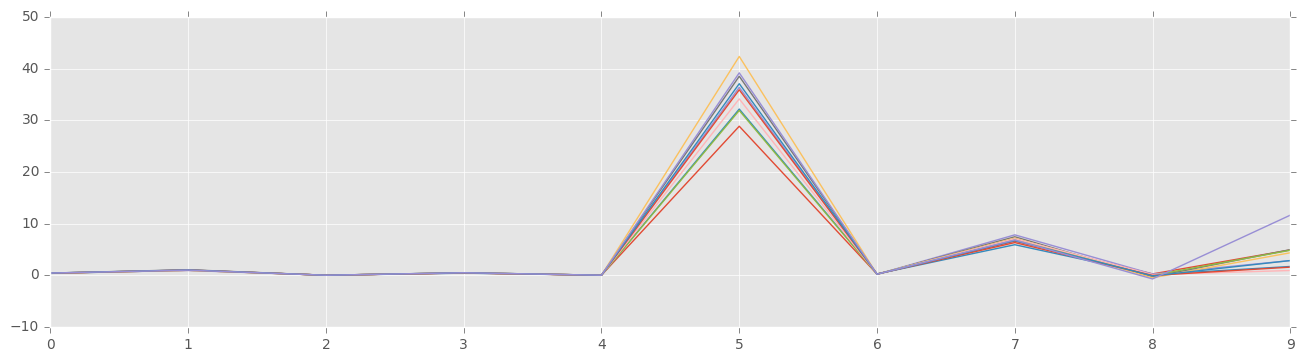

In [23]:
for i in range(feat.shape[0]):
    plt.plot(feat[i,:,10])

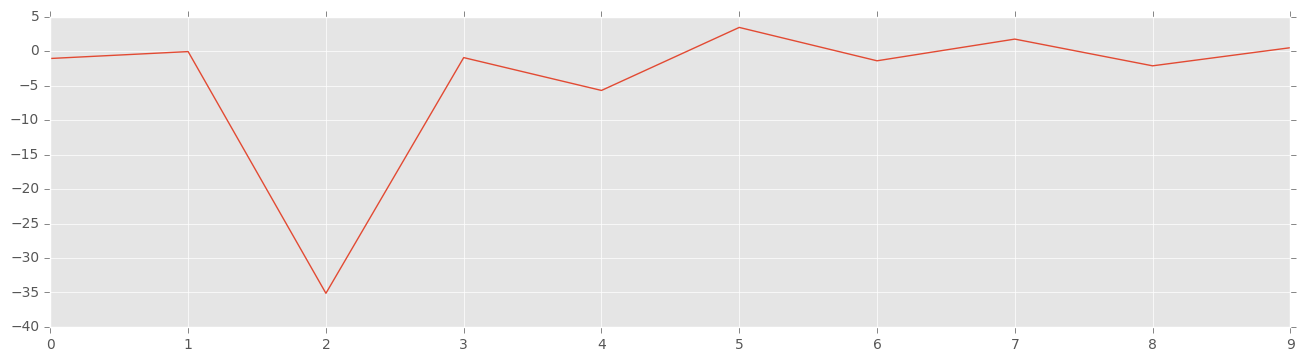

In [25]:
plt.plot(np.log(np.abs(feat[1,:,10])))

In [69]:
def set_xtick(xmin, xmax, divs=1, subdivs=10, minor=False):
    ax= plt.gca()
    if minor:
        ax.set_xticks(np.linspace(xmin, xmax, divs*(xmax-xmin)*subdivs+1), minor=True)
    ax.set_xticks(np.linspace(xmin, xmax, divs*xmax+1), minor=False)

(2000, 16)



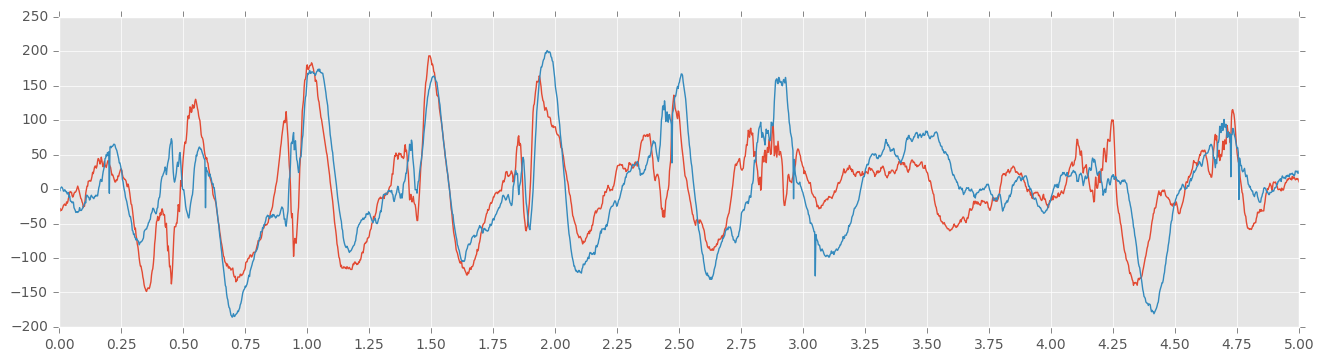

In [76]:
t_max = 5
subdiv = 2
t = np.linspace(0,t_max, SR*t_max)
seg = brief[:SR*t_max]
print(seg.shape)
seg1 = seg[:,15]
seg2 = -seg[:,11]
plt.plot(t, seg1)
plt.plot(t, seg2)
# ax= plt.gca()
# ax.set_xticks(np.linspace(0, t_max, t_max*10+1), minor=True)
# ax.set_xticks(np.linspace(0, t_max, t_max+1), minor=False)
set_xtick(0, t_max, 4, 10, False)
print("")

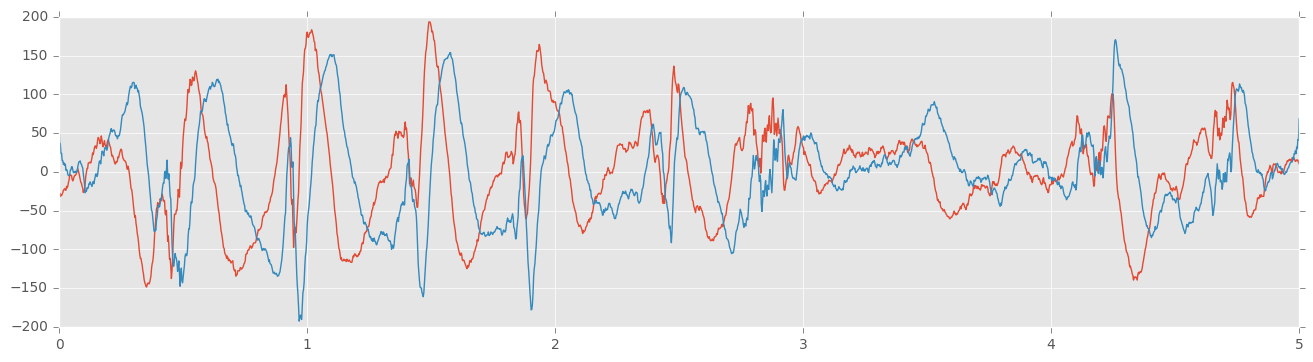

In [77]:
seg1_a = signal.hilbert(seg1)
seg2_a = signal.hilbert(seg2)
plt.plot(t, np.real(seg1_a), t, np.imag(seg1_a))

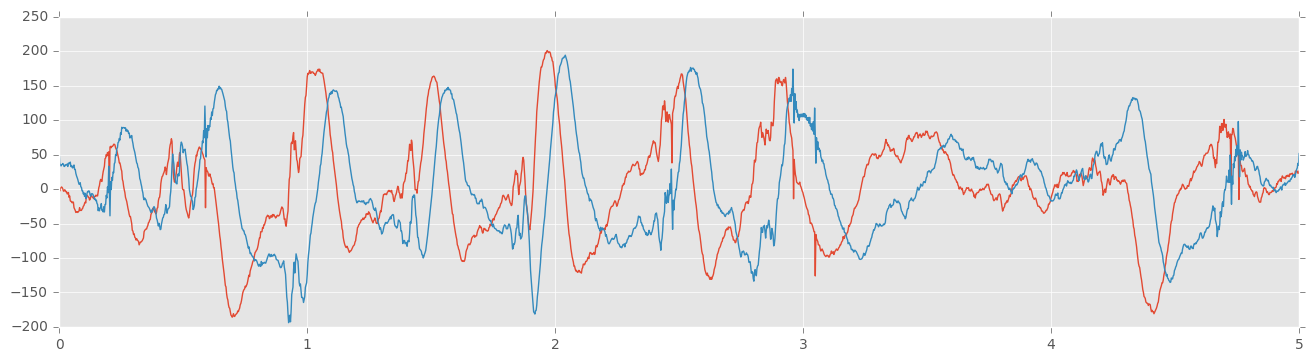

In [78]:
plt.plot(t, np.real(seg2_a), t, np.imag(seg2_a))

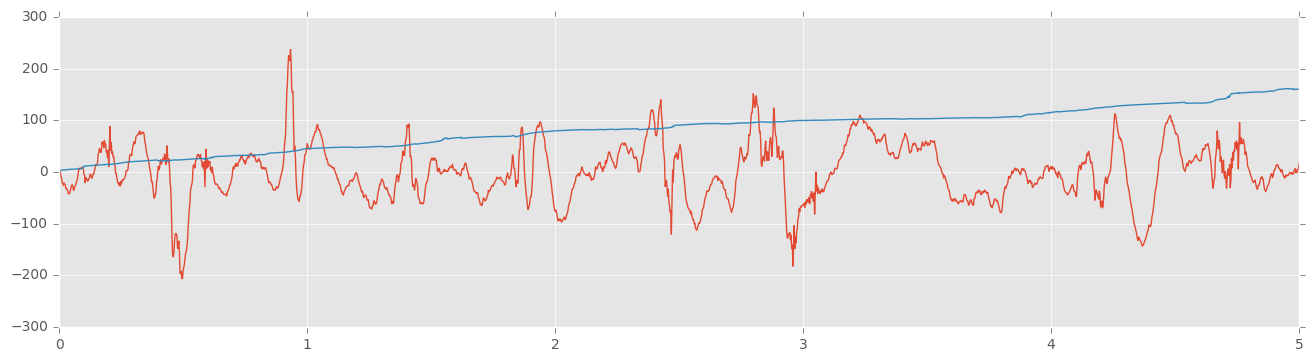

In [84]:
plt.plot(t, np.imag(seg1_a- seg2_a))
plt.plot(t, np.unwrap(np.angle(seg1_a- seg2_a)))